In [6]:
#Importing important library 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

import random

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Preprocessing the Raw Data
We have used weather time series dataset recorded on the location of the Kathmandu University, Kavre, Nepal.
This dataset contains 2 different features Wind Vane(Deg),Temperature(C). 
These were collected every 10 minutes, beginning in 2015-09-14.

In [7]:
df = pd.read_csv('Data_KU.txt' ,delimiter = "\t")

In [8]:
#Preprocess Raw Data
df2_selected_column = df[["Date & Time Stamp","CH1Avg(NRG #40 Anem. m/s)","CH7Avg(#200P Wind Vane)","CH9Avg(NRG #110S Temp  C)","CH9Max"]]
df2_selected_column.head()

# Rename column
df = df2_selected_column.rename(columns={'Date & Time Stamp':'Datetime','CH1Avg(NRG #40 Anem. m/s)': 'Wind Speed(m/s)',"CH7Avg(#200P Wind Vane)":"Wind Vane direction(Deg)","CH9Avg(NRG #110S Temp  C)":"Temperature(C)","CH9Max":"max.Temperature(C)"})
df.head()

# # Split date time
df['Datetime'] = df['Datetime'].astype('datetime64[ns]')

# df['Year'] = pd.DatetimeIndex(df['Datetime']).year
# df['Month'] = pd.DatetimeIndex(df['Datetime']).month
# df['Day'] = pd.DatetimeIndex(df['Datetime']).day
# df['Hour'] = pd.DatetimeIndex(df['Datetime']).hour
# df['Minute'] = pd.DatetimeIndex(df['Datetime']).minute

In [9]:
df

,Datetime,Wind Speed(m/s),Wind Vane direction(Deg),Temperature(C),max.Temperature(C)
0,2015-09-14 17:00:00,0.6,279,20.8,21.0
1,2015-09-14 17:10:00,0.4,263,20.7,20.7
2,2015-09-14 17:20:00,1.7,291,20.4,20.7
3,2015-09-14 17:30:00,2.0,304,20.2,20.4
4,2015-09-14 17:40:00,1.1,305,20.1,20.1
...,...,...,...,...,...
60463,2016-11-07 14:10:00,1.8,357,18.5,19.0
60464,2016-11-07 14:20:00,1.5,357,19.0,19.6
60465,2016-11-07 14:30:00,1.8,349,19.1,19.6
60466,2016-11-07 14:40:00,1.8,348,19.0,19.6


We will only take hourly data for this time, so we have to sub-sampling hte data for 10 min interval to 1h. 

In [10]:
# slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Datetime'), format='%d.%m.%Y %H:%M:%S')
df.head()

,Wind Speed(m/s),Wind Vane direction(Deg),Temperature(C),max.Temperature(C)
5,1.7,285,20.1,20.1
11,0.8,198,19.8,19.8
17,1.2,225,19.4,19.6
23,0.4,348,19.6,19.6
29,0.4,138,19.3,19.6


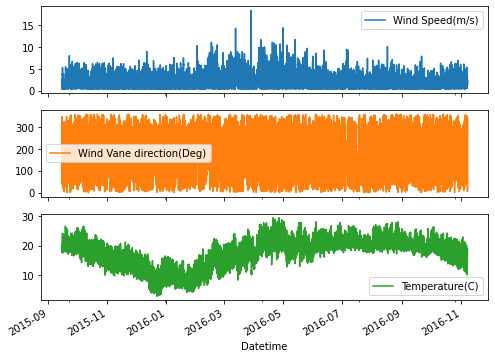

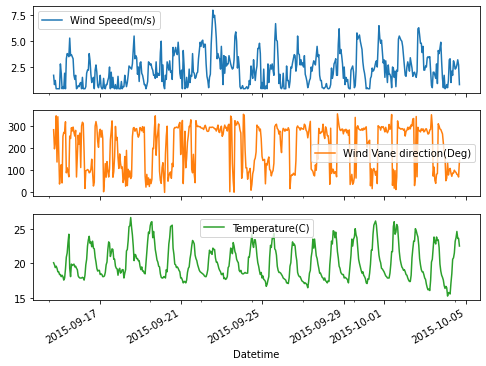

In [11]:
#Plotting the preprocessed data
#Plot of evolution of feature over time. 
plot_cols = ['Wind Speed(m/s)', 'Wind Vane direction(Deg)', 'Temperature(C)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480] # Taking 480 points as a sample 
plot_features.index = date_time[:480] # Taking 480 point as a sample
_ = plot_features.plot(subplots=True)

In [12]:
#Looking at the statistics of dataset. 

df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Wind Speed(m/s),10078.0,2.305299,1.832317,0.4,0.8,1.9,3.2,18.4
Wind Vane direction(Deg),10078.0,193.290732,103.811050,0.0,95.0,220.0,290.0,359.0
Temperature(C),10078.0,17.005993,5.029975,2.8,13.6,18.1,20.4,29.5
max.Temperature(C),10078.0,17.281068,5.081206,3.2,14.0,18.4,20.7,30.1


# Feature Engineering
It is important to understand the data abd be sure that we are passing appropriately formatted data in the model.


1. Temperature: The third column of the data, Wind Vane Direction (deg)—gives the wind direction in units of degrees. Angles do not make good model inputs: 360° and 0° should be close to each other and wrap around smoothly. There is no sense of wind vane if there is no temperature difference in surrounding. The way the air moves affects the weather, because winds move heat and cold temperatures as well as moisture from one place to another, transporting conditions from one geographical zone to another. The way winds pass each other, and the direction they move, also affects what weather a region will see on any given day.


Text(0, 0.5, 'Temperature(C)')

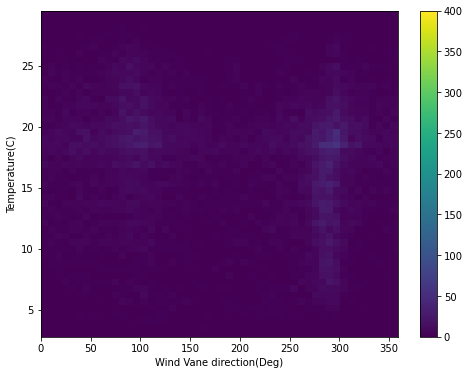

In [13]:
#Distribution of Temperature wrt wind vane direction. 

plt.hist2d(df['Wind Vane direction(Deg)'], df['Temperature(C)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Vane direction(Deg)')
plt.ylabel('Temperature(C)')

In [14]:
temp = df.pop('Temperature(C)')
max_temp = df.pop('max.Temperature(C)')

# Convert to radians.
wd_rad = df.pop('Wind Vane direction(Deg)')*np.pi / 180

# Calculate the temp x and y components.
df['Tx'] = temp*np.cos(wd_rad) # rcos(theta)
df['Ty'] = temp*np.sin(wd_rad) # 

# Calculate the max temp x and y components.
df['max_tempx'] = max_temp*np.cos(wd_rad)
df['max_tempy'] = max_temp*np.sin(wd_rad)

<ipython-input-14-08c6a730484b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tx'] = temp*np.cos(wd_rad) # rcos(theta)
<ipython-input-14-08c6a730484b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Ty'] = temp*np.sin(wd_rad) #
<ipython-input-14-08c6a730484b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

(-27.594593137141352,
 28.995583159535347,
 -28.760530600931727,
 28.092690486187223)

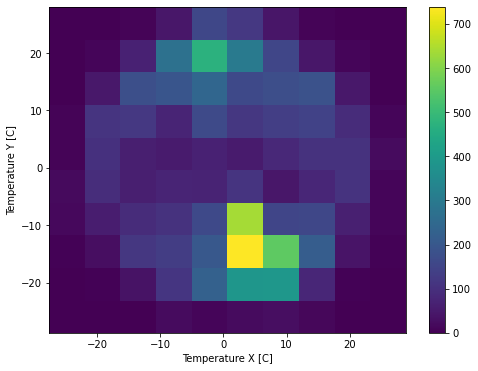

In [16]:
plt.hist2d(df['Tx'], df['Ty'])
plt.colorbar()
plt.xlabel('Temperature X [C]')
plt.ylabel('Temperature Y [C]')
ax = plt.gca()
ax.axis('tight')


(-28.092690486187223,
 29.79546131566046,
 -29.159982414833554,
 28.69040730504227)

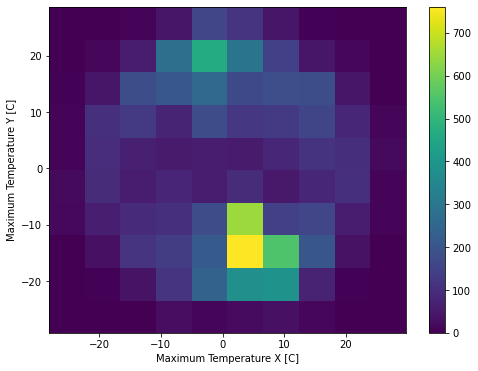

In [17]:
plt.hist2d(df['max_tempx'], df['max_tempy'])
plt.colorbar()
plt.xlabel('Maximum Temperature X [C]')
plt.ylabel('Maximum Temperature Y [C]')
ax = plt.gca()
ax.axis('tight')

In [19]:
#Converting time stamp into second
timestamp_s = date_time.map(pd.Timestamp.timestamp)
timestamp_s

5        1.442253e+09
11       1.442257e+09
17       1.442260e+09
23       1.442264e+09
29       1.442267e+09
             ...     
60443    1.478516e+09
60449    1.478519e+09
60455    1.478523e+09
60461    1.478527e+09
60467    1.478530e+09
Name: Datetime, Length: 10078, dtype: float64

In [20]:
#Transforming to sin and cosine to clear time of day and time of year signal  
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))


<ipython-input-20-4192fa565122>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
<ipython-input-20-4192fa565122>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
<ipython-input-20-4192fa565122>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

In [21]:
df

,Wind Speed(m/s),Tx,Ty,max_tempx,max_tempy,Day sin,Day cos,Year sin,Year cos
5,1.7,5.202263,-19.415109,5.202263,-19.415109,-0.999048,-0.043619,-0.957037,-0.289965
11,0.8,-18.830919,-6.118536,-18.830919,-6.118536,-0.976296,0.216440,-0.957245,-0.289279
17,1.2,-13.717872,-13.717872,-13.859293,-13.859293,-0.887011,0.461749,-0.957452,-0.288593
23,0.4,19.171693,-4.075069,19.171693,-4.075069,-0.737277,0.675590,-0.957659,-0.287906
29,0.4,-14.342695,12.914221,-14.565639,13.114960,-0.537300,0.843391,-0.957865,-0.287220
...,...,...,...,...,...,...,...,...,...
60443,1.9,14.343763,-7.950878,14.606149,-8.096321,0.300706,-0.953717,-0.800436,0.599418
60449,1.8,17.533027,1.533941,17.831885,1.560088,0.043619,-0.999048,-0.800007,0.599991
60455,2.3,9.953634,-14.756869,10.289149,-15.254291,-0.216440,-0.976296,-0.799576,0.600565
60461,2.6,17.398837,4.989036,17.687215,5.071727,-0.461749,-0.887011,-0.799146,0.601138


Text(0.5, 1.0, 'Time of day signal')

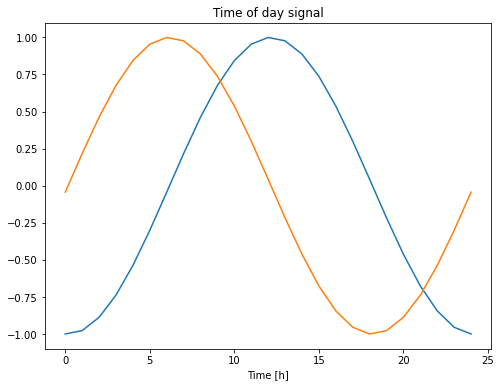

In [22]:
#Plotting time of day signal
plt.plot(np.array(df['Day sin'])[:25]) # Looking at sample of Day sin feature
plt.plot(np.array(df['Day cos'])[:25]) #  Looking at sample of Day sin feature
plt.xlabel('Time [h]')
plt.title('Time of day signal')

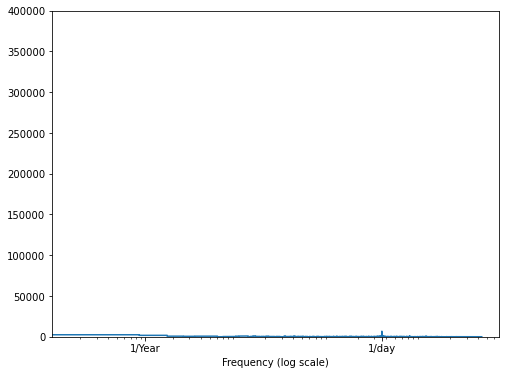

In [23]:
fft = tf.signal.rfft(df['Wind Speed(m/s)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['Wind Speed(m/s)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

# Split the data
We'll use a (70%, 20%, 10%) split for the training, validation, and test sets. Note the data is not being randomly shuffled before splitting. This is for two reasons.

It ensures that chopping the data into windows of consecutive samples is still possible.
It ensures that the validation/test results are more realistic, being evaluated on data collected after the model was trained.

In [24]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

# Normalize the data
It is important to scale features before training a neural network. Normalization is a common way of doing this scaling. Subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. We have not focused this things on this code and the validation and test sets ensure that we get (somewhat) honest metrics. So for simplicity we uses a simple average.

In [131]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / (train_std)
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std
test_df

,Wind Speed(m/s),Tx,Ty,max_tempx,max_tempy,Day sin,Day cos,Year sin,Year cos
54425,-0.374720,-1.075364,1.649897,-1.079733,1.657007,-1.193116,-0.759904,-1.603397,-0.383079
54431,-0.374720,-0.894487,1.624959,-0.888947,1.612626,-1.349143,-0.425363,-1.603474,-0.382008
54437,-1.036251,-0.916561,1.510426,-0.911320,1.499790,-1.413252,-0.061845,-1.603550,-0.380937
54443,-1.036251,-2.252014,0.140321,-2.257787,0.137802,-1.381075,0.305875,-1.603625,-0.379866
54449,-1.036251,1.628569,-0.377065,1.615187,-0.376341,-1.254805,0.652739,-1.603699,-0.378794
...,...,...,...,...,...,...,...,...,...
60443,-0.272946,1.313709,-0.421724,1.314067,-0.425160,0.424909,-1.348713,-1.326115,0.629288
60449,-0.323833,1.652759,0.278255,1.650933,0.275900,0.061328,-1.412811,-1.325509,0.630148
60455,-0.069398,0.846994,-0.924005,0.863241,-0.944832,-0.306457,-1.380640,-1.324902,0.631007
60461,0.083263,1.638493,0.533241,1.635825,0.530846,-0.653383,-1.254391,-1.324295,0.631866


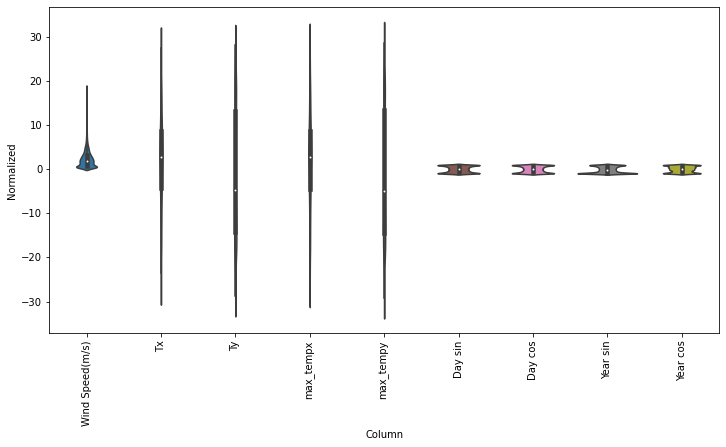

In [30]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

# Data windowing 
The main features of the input windows are:

    The width (number of time steps) of the input and label windows
    The time offset between them.
    Which features are used as inputs, labels, or both.

We have implemented various ML models including Linear, DNN, CNN and RNN models), and uses them for both:

    Single-output, and multi-output predictions.
    Single-time-step and multi-time-step predictions.

Here we focuses on implementing the data windowing so that it can be reused for all of those models.

In [31]:
# Indexes and Offsets
# input width, label width, shift(offset) 
# total window size(input width + shift), 
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)} # label columns  dhera huna ni sakxan so {Label_column1:0,label_column2:1}
      print(f"self.label_columns_indices:{self.label_columns_indices}")
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)} # Total columns {column1:0,column2:1,...} 
    print(f"self.column_indices:{self.column_indices}")
    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width) # inpute slice  garyo , mathi sano  
    self.input_indices = np.arange(self.total_window_size)[self.input_slice] # first parameter lagyo second ma slice lagyo arnage garyara return garyo

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [32]:
slice(0, 10)

slice(0, 10, None)

In [33]:
np.arange(20)[slice(0, 10)]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [35]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, label_columns=['Wind Speed(m/s)'])
w1

self.label_columns_indices:{'Wind Speed(m/s)': 0}
self.column_indices:{'Wind Speed(m/s)': 0, 'Tx': 1, 'Ty': 2, 'max_tempx': 3, 'max_tempy': 4, 'Day sin': 5, 'Day cos': 6, 'Year sin': 7, 'Year cos': 8}


Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['Wind Speed(m/s)']

In [36]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['Wind Speed(m/s)'])
w2

self.label_columns_indices:{'Wind Speed(m/s)': 0}
self.column_indices:{'Wind Speed(m/s)': 0, 'Tx': 1, 'Ty': 2, 'max_tempx': 3, 'max_tempy': 4, 'Day sin': 5, 'Day cos': 6, 'Year sin': 7, 'Year cos': 8}


Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Wind Speed(m/s)']

# Split
Given a list consecutive inputs, the split_window method will convert them to a window of inputs and a window of labels

In [38]:
#  features as a input 

def split_window(self, features):
  inputs = features[:, self.input_slice, :] # (row,column,depth) yasari slice  garxa
  labels = features[:, self.labels_slice, :] # (row,column,depth) yasari slice  garxa
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1) # jun colum ko name as deko x tyo values haru lai stack garxa

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window  #putting this function in same class

In [39]:
# Stack three slices, the length of the total window:

example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window) # Example window vaneko data ho

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 9)
Inputs shape: (3, 6, 9)
labels shape: (3, 1, 1)


In [40]:
example_window 

<tf.Tensor: shape=(3, 7, 9), dtype=float64, numpy=
array([[[-0.37472   ,  0.34187679, -1.26778312,  0.33201452,
         -1.2469089 , -1.41325215, -0.06184531, -1.54691023,
         -0.7036169 ],
        [-0.8327031 , -2.21308766, -0.28649689, -2.17778317,
         -0.2815718 , -1.38107511,  0.30587523, -1.54720292,
         -0.70258871],
        [-0.62915506, -1.66952025, -0.84732734, -1.65859367,
         -0.84355417, -1.25480463,  0.65273943, -1.54749492,
         -0.7015603 ],
        [-1.03625114,  1.8269651 , -0.13568912,  1.79084938,
         -0.13321516, -1.04304585,  0.95510906, -1.54778623,
         -0.70053166],
        [-1.03625114, -1.73594516,  1.11811941, -1.73235771,
          1.11478861, -0.76022976,  1.19237815, -1.54807684,
         -0.6995028 ],
        [-1.03625114,  1.7100271 , -0.21737925,  1.69605563,
         -0.21757983, -0.42562983,  1.34837719, -1.54836676,
         -0.69847372],
        [-1.03625114, -2.1661259 , -0.12341403, -2.15208129,
         -0.124158

In [41]:
example_inputs

<tf.Tensor: shape=(3, 6, 9), dtype=float64, numpy=
array([[[-0.37472   ,  0.34187679, -1.26778312,  0.33201452,
         -1.2469089 , -1.41325215, -0.06184531, -1.54691023,
         -0.7036169 ],
        [-0.8327031 , -2.21308766, -0.28649689, -2.17778317,
         -0.2815718 , -1.38107511,  0.30587523, -1.54720292,
         -0.70258871],
        [-0.62915506, -1.66952025, -0.84732734, -1.65859367,
         -0.84355417, -1.25480463,  0.65273943, -1.54749492,
         -0.7015603 ],
        [-1.03625114,  1.8269651 , -0.13568912,  1.79084938,
         -0.13321516, -1.04304585,  0.95510906, -1.54778623,
         -0.70053166],
        [-1.03625114, -1.73594516,  1.11811941, -1.73235771,
          1.11478861, -0.76022976,  1.19237815, -1.54807684,
         -0.6995028 ],
        [-1.03625114,  1.7100271 , -0.21737925,  1.69605563,
         -0.21757983, -0.42562983,  1.34837719, -1.54836676,
         -0.69847372]],

       [[ 0.03237609, -0.91724171, -1.2584452 , -0.91504501,
         -1.2583

In [42]:
example_labels

<tf.Tensor: shape=(3, 1, 1), dtype=float64, numpy=
array([[[-1.03625114]],

       [[-0.57826805]],

       [[ 0.18503712]]])>

# Plot
Here we used a plot method that allows a simple visualization of the split window:

In [46]:
w2.example = example_inputs, example_labels

In [47]:
def plot(self, model=None, plot_col='Wind Speed(m/s)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col] # column ko index nikaleko
  print(f"plot_col_index:{plot_col_index}")
  max_n = min(max_subplots, len(inputs))
  print(f"max_n:{max_n}")
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    print(f"ploating this : {inputs[n, :, plot_col_index]} : in figure {n}")
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10) # plot(x,y,....)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64) # scatter(x,y,...), label haru scatter gareko
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64) # scatter(x,y,...) , predition haru plot gareko

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

plot_col_index:0
max_n:3
ploating this : [-0.37472    -0.8327031  -0.62915506 -1.03625114 -1.03625114 -1.03625114] : in figure 0
ploating this : [ 0.03237609 -0.68004207  0.23592413  0.28681114 -0.27294598 -0.37472   ] : in figure 1
ploating this : [-0.8327031   0.59213321 -0.27294598  0.54124619  0.0832631   0.18503712] : in figure 2


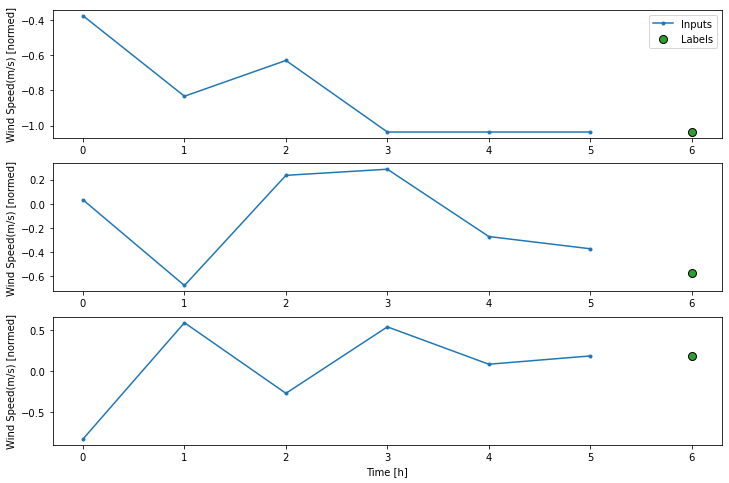

In [48]:
w2.plot() 

In [49]:
df

,Wind Speed(m/s),Tx,Ty,max_tempx,max_tempy,Day sin,Day cos,Year sin,Year cos
5,1.7,5.202263,-19.415109,5.202263,-19.415109,-0.999048,-0.043619,-0.957037,-0.289965
11,0.8,-18.830919,-6.118536,-18.830919,-6.118536,-0.976296,0.216440,-0.957245,-0.289279
17,1.2,-13.717872,-13.717872,-13.859293,-13.859293,-0.887011,0.461749,-0.957452,-0.288593
23,0.4,19.171693,-4.075069,19.171693,-4.075069,-0.737277,0.675590,-0.957659,-0.287906
29,0.4,-14.342695,12.914221,-14.565639,13.114960,-0.537300,0.843391,-0.957865,-0.287220
...,...,...,...,...,...,...,...,...,...
60443,1.9,14.343763,-7.950878,14.606149,-8.096321,0.300706,-0.953717,-0.800436,0.599418
60449,1.8,17.533027,1.533941,17.831885,1.560088,0.043619,-0.999048,-0.800007,0.599991
60455,2.3,9.953634,-14.756869,10.289149,-15.254291,-0.216440,-0.976296,-0.799576,0.600565
60461,2.6,17.398837,4.989036,17.687215,5.071727,-0.461749,-0.887011,-0.799146,0.601138


plot_col_index:1
max_n:3
ploating this : [ 0.34187679 -2.21308766 -1.66952025  1.8269651  -1.73594516  1.7100271 ] : in figure 0
ploating this : [-0.91724171 -0.55043786  0.66942336  0.44989707  0.14880495  0.76293181] : in figure 1
ploating this : [-0.4521551   0.43603499  0.9073489   0.4937164   0.6183615   0.08983745] : in figure 2


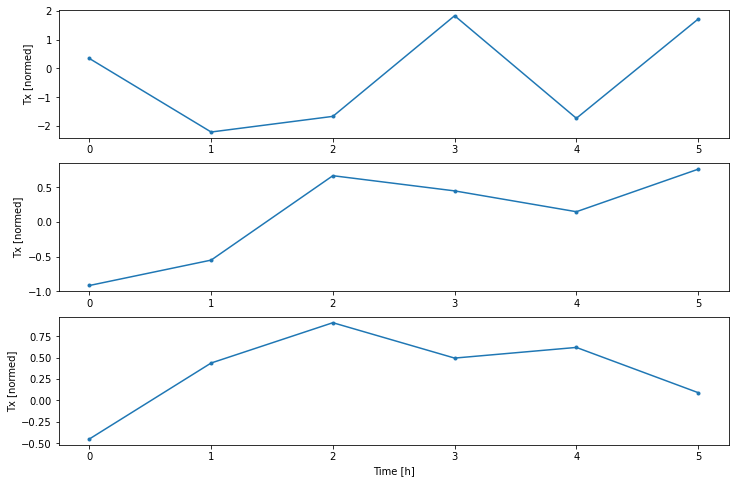

In [50]:
w2.plot(plot_col='Tx')

# Create tf.data.Dataset 
This make_dataset method will take a time series DataFrame and convert it to a tf.data.Dataset of (input_window, label_window) pairs using the preprocessing.timeseries_dataset_from_array function:

In [51]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,) # yasle k garxa ta vanda total window size lagdai data frame lai katdai , 32 ota batch akkai choti return garxa
  
  # 32 batch akkaichoti retun ta garyo tara , input label xutauna split_window ma pass garxa
  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [52]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting.""" # plot ko lagi use garxa.
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

# It will call make dataset to create data
WindowGenerator.train = train 
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [53]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 9), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [54]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features)(row,column,depth): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features)(row,column,depth): (32, 6, 9)
Labels shape (batch, time, features): (32, 1, 1)


In [55]:
#Trainning dataset
train_df.head(10)

,Wind Speed(m/s),Tx,Ty,max_tempx,max_tempy,Day sin,Day cos,Year sin,Year cos
5,-0.374720,0.341877,-1.267783,0.332015,-1.246909,-1.413252,-0.061845,-1.546910,-0.703617
11,-0.832703,-2.213088,-0.286497,-2.177783,-0.281572,-1.381075,0.305875,-1.547203,-0.702589
17,-0.629155,-1.669520,-0.847327,-1.658594,-0.843554,-1.254805,0.652739,-1.547495,-0.701560
23,-1.036251,1.826965,-0.135689,1.790849,-0.133215,-1.043046,0.955109,-1.547786,-0.700532
29,-1.036251,-1.735945,1.118119,-1.732358,1.114789,-0.760230,1.192378,-1.548077,-0.699503
35,-1.036251,1.710027,-0.217379,1.696056,-0.217580,-0.425630,1.348377,-1.548367,-0.698474
41,-1.036251,-2.166126,-0.123414,-2.152081,-0.124158,-0.062048,1.412475,-1.548656,-0.697444
47,-1.036251,1.330254,1.001069,1.327607,0.998476,0.305737,1.380304,-1.548945,-0.696415
53,0.185037,-0.142908,1.522142,-0.144200,1.497671,0.652662,1.254055,-1.549232,-0.695385
59,-0.272946,-1.342197,1.245719,-1.322288,1.225740,0.955085,1.042334,-1.549519,-0.694355


In [56]:
for train_inputs, train_labels in w2.train.take(1):
  print(f"Input sample of the one batch:{train_inputs.shape}")
  print(f"label sample of the one batch:{train_labels.shape}")
  print(train_inputs)
  print(train_labels)

Input sample of the one batch:(32, 6, 9)
label sample of the one batch:(32, 1, 1)
tf.Tensor(
[[[ 0.23592412  1.0978427   1.3281536  ... -1.3806397  -1.5104667
    0.277274  ]
  [ 0.23592412 -1.6695203   1.1774288  ... -1.2543914  -1.510098
    0.27827418]
  [ 0.28681114  1.8617816   0.41879216 ... -1.0426699  -1.5097286
    0.27927408]
  [ 0.43947217  1.0075033  -1.0891992  ... -0.75990367 -1.5093584
    0.28027368]
  [ 0.38858515 -0.00892929 -1.1707501  ... -0.42536265 -1.5089877
    0.281273  ]
  [ 0.74479425  0.6522586  -0.96224284 ... -0.06184531 -1.5086162
    0.28227204]]

 [[ 0.79568124  0.35350984 -0.6042971  ...  0.06150935  1.1436528
    0.19309881]
  [-0.37472     0.04964107 -0.68675864 ... -0.30621117  1.143964
    0.19207682]
  [ 0.43947217  0.40271127 -0.63643545 ... -0.6530754   1.1442747
    0.19105458]
  [-0.78181607  0.4417507   1.1830866  ... -0.95544505  1.1445845
    0.19003211]
  [-0.57826805  1.6129005   0.25359672 ... -1.1927141   1.1448938
    0.1890094 ]
  [-0

In [57]:
test_df.head(10)

,Wind Speed(m/s),Tx,Ty,max_tempx,max_tempy,Day sin,Day cos,Year sin,Year cos
54425,-0.374720,-1.075364,1.649897,-1.079733,1.657007,-1.193116,-0.759904,-1.603397,-0.383079
54431,-0.374720,-0.894487,1.624959,-0.888947,1.612626,-1.349143,-0.425363,-1.603474,-0.382008
54437,-1.036251,-0.916561,1.510426,-0.911320,1.499790,-1.413252,-0.061845,-1.603550,-0.380937
54443,-1.036251,-2.252014,0.140321,-2.257787,0.137802,-1.381075,0.305875,-1.603625,-0.379866
54449,-1.036251,1.628569,-0.377065,1.615187,-0.376341,-1.254805,0.652739,-1.603699,-0.378794
54455,-0.120285,-1.625924,1.113467,-1.616024,1.105725,-1.043046,0.955109,-1.603773,-0.377723
54461,-1.036251,-1.006793,1.405571,-1.005556,1.402892,-0.760230,1.192378,-1.603846,-0.376651
54467,-1.036251,-0.732768,1.427801,-0.726511,1.411842,-0.425630,1.348377,-1.603918,-0.375580
54473,-1.036251,1.425285,-0.464658,1.423672,-0.467397,-0.062048,1.412475,-1.603989,-0.374508
54479,-1.036251,1.655321,0.074446,1.653492,0.071985,0.305737,1.380304,-1.604060,-0.373437


In [58]:
for test_inputs, test_labels in w2.test.take(1):
  print(test_inputs)
  print(test_labels)

tf.Tensor(
[[[ 0.6430202   1.4444302   1.031122   ... -1.2543914  -1.5367633
    0.19964077]
  [ 0.0832631   1.6774988   0.7215842  ... -1.0426699  -1.5364468
    0.200661  ]
  [-0.22205897  1.5657189  -0.54711866 ... -0.75990367 -1.5361298
    0.20168099]
  [ 0.8465683   0.43239897 -1.0624311  ... -0.42536265 -1.535812
    0.20270073]
  [ 1.0501163   0.11003786 -1.0995595  ... -0.06184531 -1.5354935
    0.20372023]
  [ 1.2027774   0.4618569  -0.99135053 ...  0.30587524 -1.5351744
    0.2047395 ]]

 [[ 1.2536644   0.8707735  -0.94847846 ... -0.42536265 -1.5021299
    0.29939097]
  [ 1.3554384   0.28404513 -1.033853   ... -0.06184531 -1.5017463
    0.3003848 ]
  [ 0.8465683   0.20289573 -0.9878343  ...  0.30587524 -1.501362
    0.3013783 ]
  [ 0.03237608  0.14247394 -0.989945   ...  0.6527394  -1.5009769
    0.30237153]
  [ 0.18503712  0.48970938 -0.8783624  ...  0.95510906 -1.5005913
    0.3033645 ]
  [-0.323833   -0.18260251 -0.97129524 ...  1.1923782  -1.5002049
    0.3043571 ]]

 [[

# Single Step Model
Current hours features as input, one hour ahead label as lebel. When we provide current features, then it will predict level of 1 hour ahead. 
The simplest model you can build on this sort of data is one that predicts a single feature's value, 1 timestep (1h) in the future based only on the current conditions.

So start by building models to predict the wind velocity(m/s) value 1h into the future.

In [59]:
# Making window for single step model
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Wind Speed(m/s)'])
single_step_window

self.label_columns_indices:{'Wind Speed(m/s)': 0}
self.column_indices:{'Wind Speed(m/s)': 0, 'Tx': 1, 'Ty': 2, 'max_tempx': 3, 'max_tempy': 4, 'Day sin': 5, 'Day cos': 6, 'Year sin': 7, 'Year cos': 8}


Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Wind Speed(m/s)']

In [61]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 9)
Labels shape (batch, time, features): (32, 1, 1)


# Performance Baseline
Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models.

This first task is to predict wind velocity 1h in the future given the current value of all features. The current values include the current wind velocity(like as training label).

So start with a model that just returns the current wind velocity as the prediction, predicting "No change". This is a reasonable baseline since wind velocity changes slowly. Of course, this baseline will work less well if you make a prediction further in the future.

In [62]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [63]:
#Instantiate and evaluate this model
baseline = Baseline(label_index=column_indices['Wind Speed(m/s)'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

63/63 [==============================] - 2s 4ms/step - loss: 0.3959 - mean_absolute_error: 0.4556


In [64]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['Wind Speed(m/s)'])

wide_window

self.label_columns_indices:{'Wind Speed(m/s)': 0}
self.column_indices:{'Wind Speed(m/s)': 0, 'Tx': 1, 'Ty': 2, 'max_tempx': 3, 'max_tempy': 4, 'Day sin': 5, 'Day cos': 6, 'Year sin': 7, 'Year cos': 8}


Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Wind Speed(m/s)']

In [65]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 9)
Output shape: (32, 24, 1)


plot_col_index:0
max_n:3
ploating this : [ 0.74479425  0.0832631  -0.6800421  -0.22205897  0.5921332  -0.476494
 -1.0362512  -0.57826805 -0.78181607 -0.42560703 -1.0362512  -0.8835901
 -0.93447715 -0.62915504  0.0832631   2.0678566   3.3400319   3.3909187
  3.3909187   4.205111    2.7802746   1.6607604   3.0347097   2.0678566 ] : in figure 0
ploating this : [ 1.8643085   1.2536644   0.94834226  0.4903592   0.33769816 -0.12028494
 -0.17117196 -0.62915504 -0.98536414 -1.0362512  -1.0362512  -1.0362512
 -0.98536414 -0.78181607 -0.06939793 -0.12028494 -0.27294597 -0.7309291
 -0.6800421  -0.57826805 -0.78181607  0.94834226  1.5589864   1.3045514 ] : in figure 1
ploating this : [ 1.2536644   1.4572124   0.8974553   0.8974553   0.0832631  -0.7309291
 -1.0362512  -1.0362512  -1.0362512  -0.98536414 -0.22205897 -0.98536414
 -0.62915504 -0.8327031  -1.0362512  -0.12028494 -0.93447715 -0.62915504
  0.28681114 -0.22205897 -0.476494   -0.12028494  0.18503712  0.6939072 ] : in figure 2


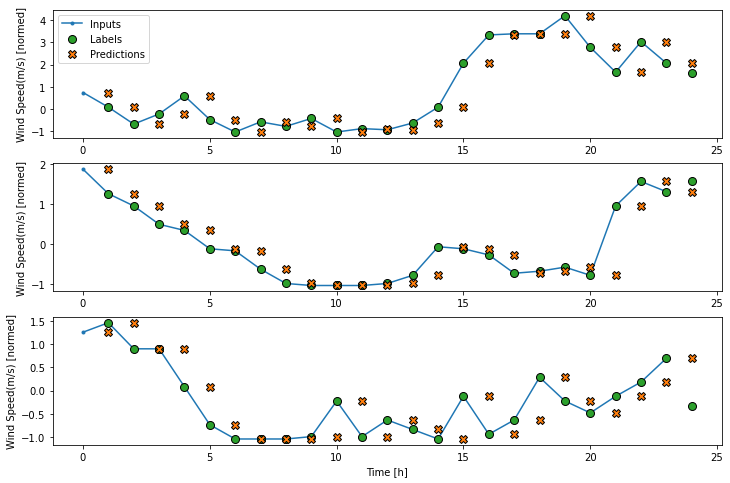

In [66]:
#Plotting the baseline model's predictions you can see that it is simply the labels, shifted right by 1h.
wide_window.plot(baseline)

# Simple Linear Model 
In the simplest trainable model. In this model we insert linear transformation between the input and output. In this case the output from a time step only depends on that step:

In [67]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1) # only one neuron with no activation meaning only linear function
])

In [68]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 9)
Output shape: (32, 1, 1)


In [69]:
MAX_EPOCHS = 200

def compile_and_fit(model, window, patience=5):
  # If after 2 epochs, the loss is not imporoved, we have to stop 
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  # Set loss, optimizer, and matrices
  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])
  log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
 
  # Training start
  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping,tensorboard_callback])
  return history

In [70]:
#Train the model and evaluate its performance
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/200
221/221 [==============================] - 5s 12ms/step - loss: 1.9001 - mean_absolute_error: 1.1139 - val_loss: 2.7651 - val_mean_absolute_error: 1.3357
Epoch 2/200
221/221 [==============================] - 1s 3ms/step - loss: 1.2446 - mean_absolute_error: 0.8941 - val_loss: 1.6507 - val_mean_absolute_error: 1.0197
Epoch 3/200
221/221 [==============================] - 1s 3ms/step - loss: 0.8804 - mean_absolute_error: 0.7420 - val_loss: 1.0988 - val_mean_absolute_error: 0.8207
Epoch 4/200
221/221 [==============================] - 1s 3ms/step - loss: 0.6754 - mean_absolute_error: 0.6399 - val_loss: 0.8032 - val_mean_absolute_error: 0.6951
Epoch 5/200
221/221 [==============================] - 1s 3ms/step - loss: 0.5576 - mean_absolute_error: 0.5734 - val_loss: 0.6414 - val_mean_absolute_error: 0.6176
Epoch 6/200
221/221 [==============================] - 1s 3ms/step - loss: 0.4865 - mean_absolute_error: 0.5299 - val_loss: 0.5368 - val_mean_absolute_error: 0.5621
Epoch 7/2

In [71]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 9)
Output shape: (32, 24, 1)


In [72]:
linear

plot_col_index:0
max_n:3
ploating this : [ 0.74479425  0.0832631  -0.6800421  -0.22205897  0.5921332  -0.476494
 -1.0362512  -0.57826805 -0.78181607 -0.42560703 -1.0362512  -0.8835901
 -0.93447715 -0.62915504  0.0832631   2.0678566   3.3400319   3.3909187
  3.3909187   4.205111    2.7802746   1.6607604   3.0347097   2.0678566 ] : in figure 0
ploating this : [ 1.8643085   1.2536644   0.94834226  0.4903592   0.33769816 -0.12028494
 -0.17117196 -0.62915504 -0.98536414 -1.0362512  -1.0362512  -1.0362512
 -0.98536414 -0.78181607 -0.06939793 -0.12028494 -0.27294597 -0.7309291
 -0.6800421  -0.57826805 -0.78181607  0.94834226  1.5589864   1.3045514 ] : in figure 1
ploating this : [ 1.2536644   1.4572124   0.8974553   0.8974553   0.0832631  -0.7309291
 -1.0362512  -1.0362512  -1.0362512  -0.98536414 -0.22205897 -0.98536414
 -0.62915504 -0.8327031  -1.0362512  -0.12028494 -0.93447715 -0.62915504
  0.28681114 -0.22205897 -0.476494   -0.12028494  0.18503712  0.6939072 ] : in figure 2


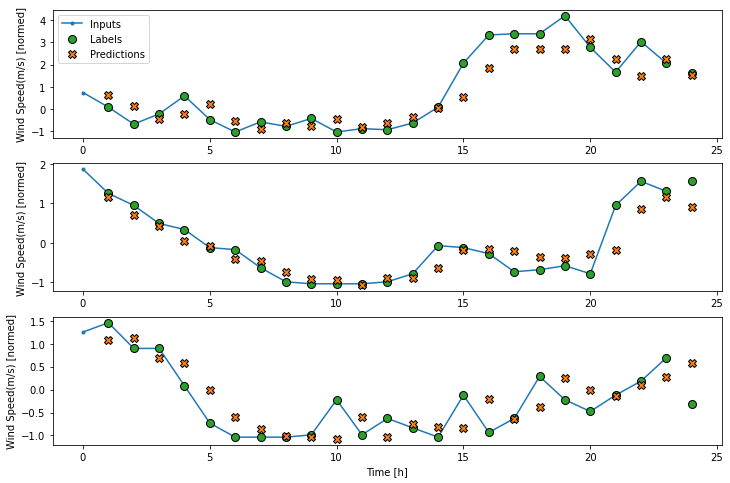

In [73]:
# inputs, labels = self.example  
wide_window.plot(linear) 

In [74]:
linear.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, None, 1)           10        
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


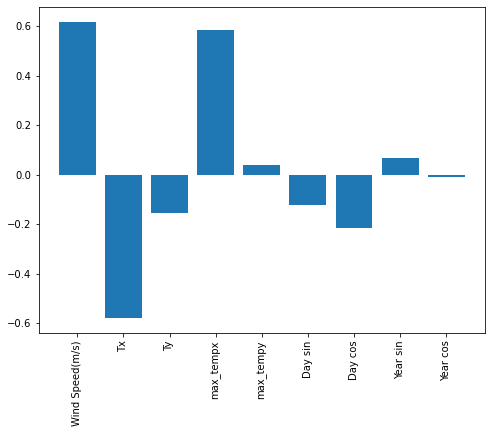

In [75]:
# Only weight not bias
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

# Dense ( Ann or DNN , linear + activation function)
Before applying models that actually operate on multiple time-steps, it's worth checking the performance of deeper, more powerful, single input step models.

Here's a model similar to the linear model, except it stacks several a few Dense layers between the input and the output:

In [76]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'), # 64 neurons with linear function + activation function 
    tf.keras.layers.Dense(units=64, activation='relu'), # same as above
    tf.keras.layers.Dense(units=1) # On Final layer, only one neuron with no activation function
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/200
221/221 [==============================] - 3s 6ms/step - loss: 0.3826 - mean_absolute_error: 0.4569 - val_loss: 0.3418 - val_mean_absolute_error: 0.4417
Epoch 2/200
221/221 [==============================] - 1s 5ms/step - loss: 0.3373 - mean_absolute_error: 0.4217 - val_loss: 0.3404 - val_mean_absolute_error: 0.4438
Epoch 3/200
221/221 [==============================] - 1s 5ms/step - loss: 0.3309 - mean_absolute_error: 0.4178 - val_loss: 0.3391 - val_mean_absolute_error: 0.4442
Epoch 4/200
221/221 [==============================] - 1s 4ms/step - loss: 0.3311 - mean_absolute_error: 0.4167 - val_loss: 0.3373 - val_mean_absolute_error: 0.4382
Epoch 5/200
221/221 [==============================] - 1s 3ms/step - loss: 0.3254 - mean_absolute_error: 0.4139 - val_loss: 0.3405 - val_mean_absolute_error: 0.4426
Epoch 6/200
221/221 [==============================] - 1s 4ms/step - loss: 0.3217 - mean_absolute_error: 0.4118 - val_loss: 0.3381 - val_mean_absolute_error: 0.4400
Epoch 7/20

In [77]:
dense.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1, 64)             640       
                                                                 
 dense_2 (Dense)             (None, 1, 64)             4160      
                                                                 
 dense_3 (Dense)             (None, 1, 1)              65        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


plot_col_index:0
max_n:3
ploating this : [ 0.74479425  0.0832631  -0.6800421  -0.22205897  0.5921332  -0.476494
 -1.0362512  -0.57826805 -0.78181607 -0.42560703 -1.0362512  -0.8835901
 -0.93447715 -0.62915504  0.0832631   2.0678566   3.3400319   3.3909187
  3.3909187   4.205111    2.7802746   1.6607604   3.0347097   2.0678566 ] : in figure 0
ploating this : [ 1.8643085   1.2536644   0.94834226  0.4903592   0.33769816 -0.12028494
 -0.17117196 -0.62915504 -0.98536414 -1.0362512  -1.0362512  -1.0362512
 -0.98536414 -0.78181607 -0.06939793 -0.12028494 -0.27294597 -0.7309291
 -0.6800421  -0.57826805 -0.78181607  0.94834226  1.5589864   1.3045514 ] : in figure 1
ploating this : [ 1.2536644   1.4572124   0.8974553   0.8974553   0.0832631  -0.7309291
 -1.0362512  -1.0362512  -1.0362512  -0.98536414 -0.22205897 -0.98536414
 -0.62915504 -0.8327031  -1.0362512  -0.12028494 -0.93447715 -0.62915504
  0.28681114 -0.22205897 -0.476494   -0.12028494  0.18503712  0.6939072 ] : in figure 2


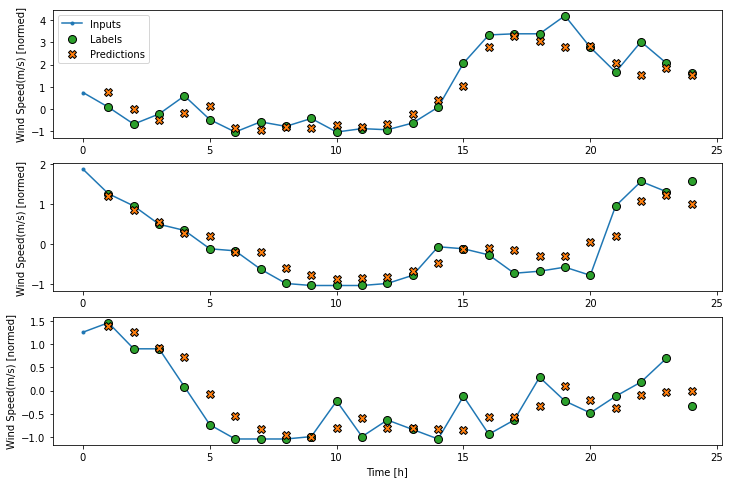

In [78]:
wide_window.plot(dense) # inputs, labels = self.example

# Multi-step dense
A single-time-step model has no context for the current values of its inputs. It can't see how the input features are changing over time. To address this issue the model needs access to multiple time steps when making predictions. 
The baseline, linear and dense models handled each time step independently. Here the model will take multiple time steps as input to produce a single output.

Create a WindowGenerator that will produce batches of the 3h of inputs and, 1h of labels:

Note that the Window's shift parameter is relative to the end of the two windows.

In [79]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Wind Speed(m/s)'])

conv_window

self.label_columns_indices:{'Wind Speed(m/s)': 0}
self.column_indices:{'Wind Speed(m/s)': 0, 'Tx': 1, 'Ty': 2, 'max_tempx': 3, 'max_tempy': 4, 'Day sin': 5, 'Day cos': 6, 'Year sin': 7, 'Year cos': 8}


Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['Wind Speed(m/s)']

plot_col_index:0
max_n:3
ploating this : [-1.0362512  -0.93447715 -1.0362512 ] : in figure 0
ploating this : [-1.0362512  -1.0362512  -0.27294597] : in figure 1
ploating this : [-0.12028494  0.79568124  0.74479425] : in figure 2


Text(0.5, 1.0, 'Given 3h as input, predict 1h into the future.')

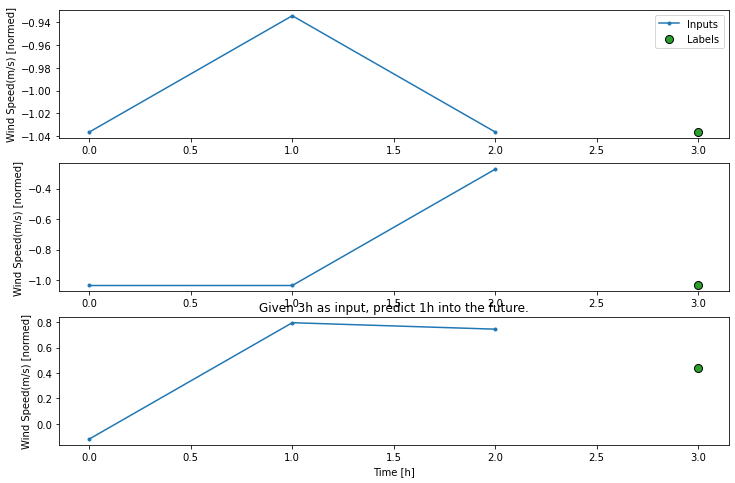

In [80]:
conv_window.plot()
plt.title("Given 3h as input, predict 1h into the future.")

In [81]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [82]:
print('Input shape(batch,time,features):', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape(batch,time,features): (32, 3, 9)
Output shape: (32, 1, 1)


In [83]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

63/63 [==============================] - 0s 2ms/step - loss: 0.3321 - mean_absolute_error: 0.4353


In [84]:
multi_step_dense.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 27)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                896       
                                                                 
 dense_5 (Dense)             (None, 32)                1056      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
 reshape (Reshape)           (None, 1, 1)              0         
                                                                 
Total params: 1,985
Trainable params: 1,985
Non-trainable params: 0
_________________________________________________________________


plot_col_index:0
max_n:3
ploating this : [-1.0362512  -0.93447715 -1.0362512 ] : in figure 0
ploating this : [-1.0362512  -1.0362512  -0.27294597] : in figure 1
ploating this : [-0.12028494  0.79568124  0.74479425] : in figure 2


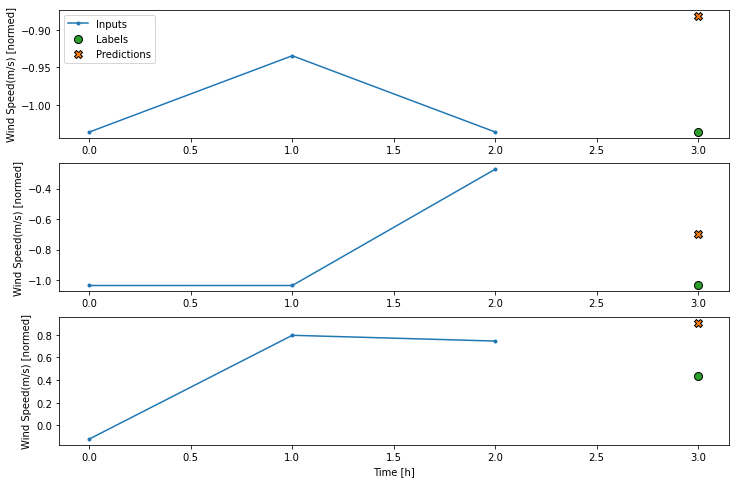

In [85]:
conv_window.plot(multi_step_dense)

In [86]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 9)

ValueError:Exception encountered when calling layer "sequential_2" (type Sequential).

Input 0 of layer "dense_4" is incompatible with the layer: expected axis -1of input shape to have value 27, but received input with shape (32, 216)

Call arguments received:
  • inputs=tf.Tensor(shape=(32, 24, 9), dtype=float32)
  • training=None
  • mask=None


# Convolution neural network
Convolution layer (layers.Conv1D) also takes multiple time steps as input to each prediction
The layers.Flatten and the first layers.Dense are replaced by a layers.Conv1D.
The layers.Reshape is no longer necessary since the convolution keeps the time axis in its output

In [87]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [88]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 9)
Output shape: (32, 1, 1)


In [89]:
#Train and evaluate it on the conv_window and it should give performance similar to the multi_step_dense model.
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

63/63 [==============================] - 0s 2ms/step - loss: 0.3354 - mean_absolute_error: 0.4377


In [90]:
conv_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 32)             896       
                                                                 
 dense_7 (Dense)             (None, 1, 32)             1056      
                                                                 
 dense_8 (Dense)             (None, 1, 1)              33        
                                                                 
Total params: 1,985
Trainable params: 1,985
Non-trainable params: 0
_________________________________________________________________


In [91]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 9)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


In [92]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Wind Speed(m/s)'])

wide_conv_window

self.label_columns_indices:{'Wind Speed(m/s)': 0}
self.column_indices:{'Wind Speed(m/s)': 0, 'Tx': 1, 'Ty': 2, 'max_tempx': 3, 'max_tempy': 4, 'Day sin': 5, 'Day cos': 6, 'Year sin': 7, 'Year cos': 8}


Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['Wind Speed(m/s)']

In [93]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 9)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


plot_col_index:0
max_n:3
ploating this : [ 0.38858515  0.03237608 -0.27294597  0.6939072   1.2536644   0.5412462
  0.18503712 -0.323833    0.03237608  0.1341501  -1.0362512  -0.37472
 -0.17117196 -1.0362512  -0.7309291  -0.78181607 -1.0362512  -1.0362512
 -0.98536414 -0.93447715 -0.8327031  -0.57826805 -0.323833   -0.37472
  0.23592412  0.18503712] : in figure 0
ploating this : [-0.78181607 -0.323833   -1.0362512  -0.98536414 -1.0362512  -1.0362512
 -1.0362512  -0.93447715 -1.0362512  -0.27294597 -0.7309291  -1.0362512
 -0.42560703 -0.22205897 -0.52738106  0.23592412  0.23592412  0.28681114
  0.43947217  0.38858515  0.74479425  1.9151955   0.28681114  0.18503712
 -0.12028494 -0.57826805] : in figure 1
ploating this : [-0.7309291  -0.57826805  0.4903592  -0.323833    0.23592412  0.5921332
  0.79568124  0.03237608  0.43947217  0.1341501  -0.12028494 -0.22205897
 -0.17117196  0.28681114 -0.93447715 -0.476494   -0.93447715 -1.0362512
 -0.17117196 -0.17117196 -0.42560703 -0.17117196 -0.6291

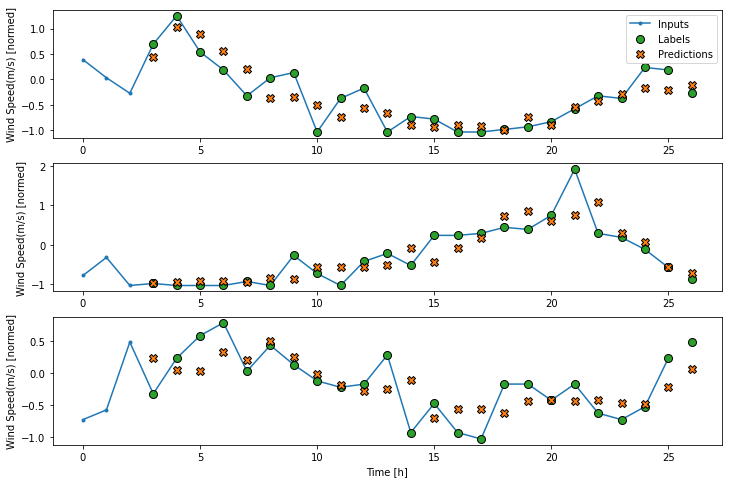

In [94]:
wide_conv_window.plot(conv_model)

# Recurrent neural network
A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.
For more details, read the text generation tutorial or the RNN guide.
In this code we use an RNN layer called Long Short Term Memory (LSTM).

In [95]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [96]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 9)
Output shape: (32, 24, 1)


In [97]:
wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['Wind Speed(m/s)']

In [98]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

63/63 [==============================] - 0s 4ms/step - loss: 0.3689 - mean_absolute_error: 0.4601


plot_col_index:0
max_n:3
ploating this : [ 0.74479425  0.0832631  -0.6800421  -0.22205897  0.5921332  -0.476494
 -1.0362512  -0.57826805 -0.78181607 -0.42560703 -1.0362512  -0.8835901
 -0.93447715 -0.62915504  0.0832631   2.0678566   3.3400319   3.3909187
  3.3909187   4.205111    2.7802746   1.6607604   3.0347097   2.0678566 ] : in figure 0
ploating this : [ 1.8643085   1.2536644   0.94834226  0.4903592   0.33769816 -0.12028494
 -0.17117196 -0.62915504 -0.98536414 -1.0362512  -1.0362512  -1.0362512
 -0.98536414 -0.78181607 -0.06939793 -0.12028494 -0.27294597 -0.7309291
 -0.6800421  -0.57826805 -0.78181607  0.94834226  1.5589864   1.3045514 ] : in figure 1
ploating this : [ 1.2536644   1.4572124   0.8974553   0.8974553   0.0832631  -0.7309291
 -1.0362512  -1.0362512  -1.0362512  -0.98536414 -0.22205897 -0.98536414
 -0.62915504 -0.8327031  -1.0362512  -0.12028494 -0.93447715 -0.62915504
  0.28681114 -0.22205897 -0.476494   -0.12028494  0.18503712  0.6939072 ] : in figure 2


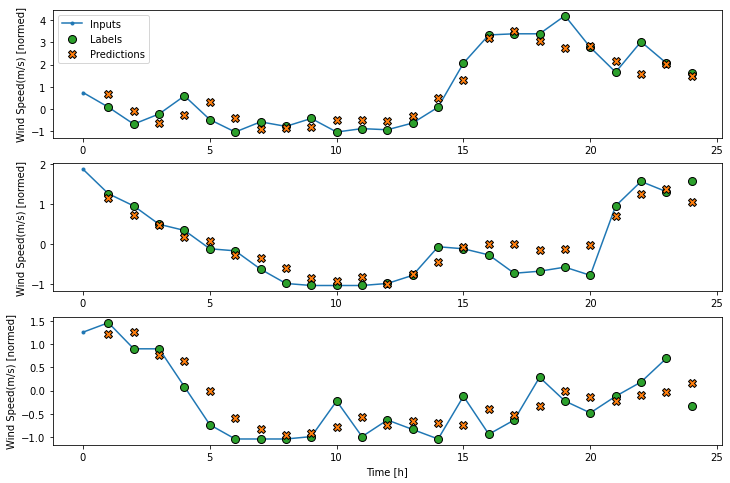

In [99]:
wide_window.plot(lstm_model)

In [100]:
lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 32)            5376      
                                                                 
 dense_9 (Dense)             (None, 24, 1)             33        
                                                                 
Total params: 5,409
Trainable params: 5,409
Non-trainable params: 0
_________________________________________________________________


# Performance
With this dataset typically each of the models does slightly better than the one before it.

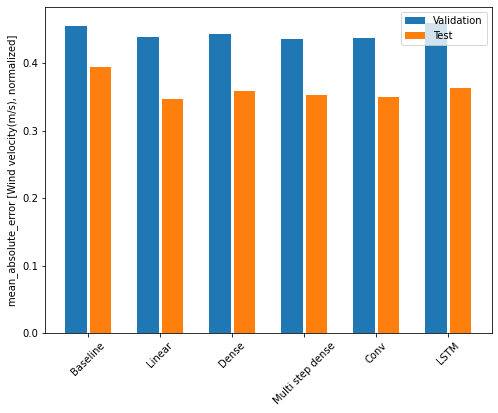

In [101]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Wind velocity(m/s), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

# Multi-output models 
The models so far all predicted a single output feature, Wind  velocity(m/s), for a single time step.

All of these models can be converted to predict multiple features just by changing the number of units in the output layer and adjusting the training windows to include all features in the labels.

In [102]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

self.column_indices:{'Wind Speed(m/s)': 0, 'Tx': 1, 'Ty': 2, 'max_tempx': 3, 'max_tempy': 4, 'Day sin': 5, 'Day cos': 6, 'Year sin': 7, 'Year cos': 8}
self.column_indices:{'Wind Speed(m/s)': 0, 'Tx': 1, 'Ty': 2, 'max_tempx': 3, 'max_tempy': 4, 'Day sin': 5, 'Day cos': 6, 'Year sin': 7, 'Year cos': 8}
Inputs shape (batch, time, features): (32, 24, 9)
Labels shape (batch, time, features): (32, 24, 9)


# Baseline
The same baseline model can be used here, but this time repeating all features instead of selecting a specific label_index.

In [103]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [104]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

63/63 [==============================] - 1s 2ms/step - loss: 0.7238 - mean_absolute_error: 0.4689


plot_col_index:0
max_n:3
ploating this : [ 0.28681114  1.5589864   1.1518903   1.2027774   1.4063253   0.74479425
  1.5589864   1.0501163   0.74479425  0.9992293   0.23592412 -0.42560703
 -0.78181607 -1.0362512  -1.0362512  -1.0362512  -0.6800421  -0.37472
 -0.476494    0.0832631   0.4903592  -0.62915504 -0.323833    1.9151955 ] : in figure 0
ploating this : [-1.0362512  -0.52738106 -0.42560703 -0.01851093 -0.17117196 -0.12028494
  0.03237608  0.23592412  0.33769816  0.03237608  1.1010033   2.0678566
  1.4572124   1.2027774   1.3554384   0.79568124  0.23592412  0.38858515
 -0.476494    0.33769816 -0.17117196 -0.7309291   0.1341501  -0.323833  ] : in figure 1
ploating this : [-0.93447715 -0.98536414 -1.0362512  -0.98536414 -0.42560703 -0.323833
 -0.27294597  0.23592412 -0.27294597  0.0832631  -0.7309291   0.8974553
  1.4063253   1.0501163   1.1518903   0.03237608 -0.98536414 -1.0362512
 -0.93447715 -1.0362512  -0.8327031  -1.0362512  -1.0362512  -0.8327031 ] : in figure 2


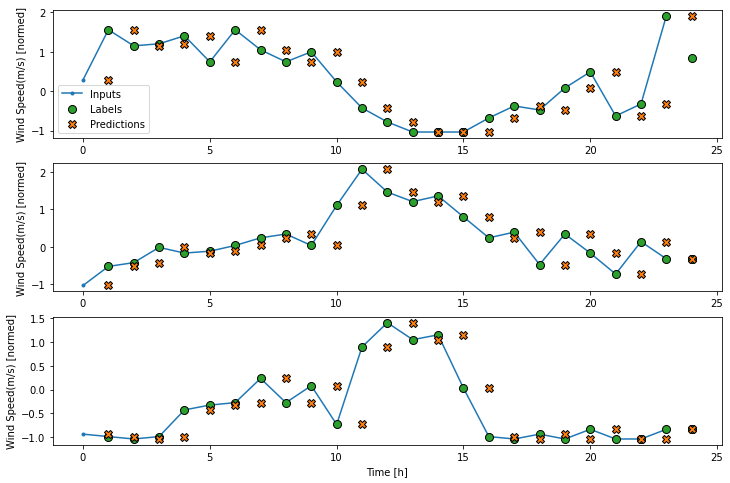

In [105]:
wide_window.plot(baseline)

# Dense

In [106]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [107]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

63/63 [==============================] - 0s 2ms/step - loss: 0.5052 - mean_absolute_error: 0.4409


plot_col_index:0
max_n:3
ploating this : [ 0.28681114  1.5589864   1.1518903   1.2027774   1.4063253   0.74479425
  1.5589864   1.0501163   0.74479425  0.9992293   0.23592412 -0.42560703
 -0.78181607 -1.0362512  -1.0362512  -1.0362512  -0.6800421  -0.37472
 -0.476494    0.0832631   0.4903592  -0.62915504 -0.323833    1.9151955 ] : in figure 0
ploating this : [-1.0362512  -0.52738106 -0.42560703 -0.01851093 -0.17117196 -0.12028494
  0.03237608  0.23592412  0.33769816  0.03237608  1.1010033   2.0678566
  1.4572124   1.2027774   1.3554384   0.79568124  0.23592412  0.38858515
 -0.476494    0.33769816 -0.17117196 -0.7309291   0.1341501  -0.323833  ] : in figure 1
ploating this : [-0.93447715 -0.98536414 -1.0362512  -0.98536414 -0.42560703 -0.323833
 -0.27294597  0.23592412 -0.27294597  0.0832631  -0.7309291   0.8974553
  1.4063253   1.0501163   1.1518903   0.03237608 -0.98536414 -1.0362512
 -0.93447715 -1.0362512  -0.8327031  -1.0362512  -1.0362512  -0.8327031 ] : in figure 2


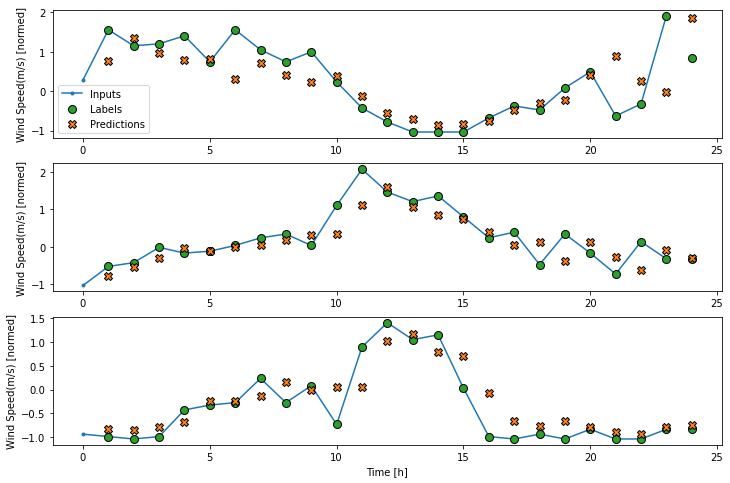

In [108]:
wide_window.plot(dense)

# RNN

In [109]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

63/63 [==============================] - 0s 4ms/step - loss: 0.5463 - mean_absolute_error: 0.4759

Wall time: 39.4 s


In [110]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each timestep is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [111]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

63/63 [==============================] - 0s 4ms/step - loss: 0.5530 - mean_absolute_error: 0.4391

Wall time: 35.5 s
Parser   : 132 ms


# Performance

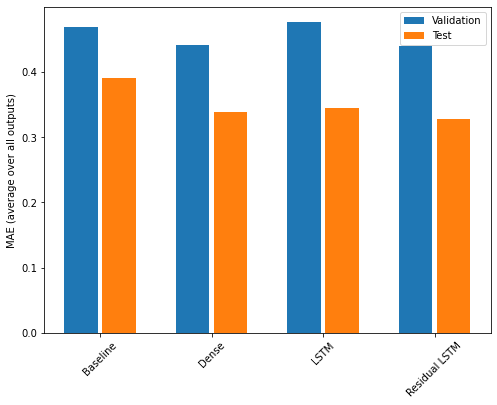

In [112]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [113]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.3898
Dense          : 0.3384
LSTM           : 0.3448
Residual LSTM  : 0.3271


# Multi-step models
Both the single-output and multiple-output models in the previous sections made single time step predictions, 1h into the future.

This section looks at how to expand these models to make multiple time step predictions.

In a multi-step prediction, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predicts a sequence of the future values.

There are two rough approaches to this:

Single shot predictions where the entire time series is predicted at once.
Autoregressive predictions where the model only makes single step predictions and its output is fed back as its input.
In this section all the models will predict all the features across all output time steps.

For the multi-step model, the training data again consists of hourly samples. However, here, the models will learn to predict 24h of the future, given 24h of the past.

Here is a Window object that generates these slices from the dataset:

self.column_indices:{'Wind Speed(m/s)': 0, 'Tx': 1, 'Ty': 2, 'max_tempx': 3, 'max_tempy': 4, 'Day sin': 5, 'Day cos': 6, 'Year sin': 7, 'Year cos': 8}
plot_col_index:0
max_n:3
ploating this : [-0.12028494 -0.17117196 -0.62915504 -0.98536414 -1.0362512  -1.0362512
 -1.0362512  -0.98536414 -0.78181607 -0.06939793 -0.12028494 -0.27294597
 -0.7309291  -0.6800421  -0.57826805 -0.78181607  0.94834226  1.5589864
  1.3045514   1.5589864   1.2027774   0.79568124  1.3554384   0.9992293 ] : in figure 0
ploating this : [ 0.38858515 -0.57826805 -0.62915504 -0.01851093 -0.57826805 -0.323833
 -1.0362512  -0.98536414 -0.98536414 -0.52738106 -0.06939793  0.03237608
 -0.62915504  0.03237608 -0.37472    -0.98536414 -0.52738106 -0.52738106
  0.38858515  0.1341501   1.3554384   0.8974553  -0.52738106  1.0501163 ] : in figure 1
ploating this : [-0.17117196 -0.06939793  0.1341501  -0.323833    0.43947217 -0.01851093
 -0.93447715  0.4903592  -0.323833    1.2027774   0.28681114 -0.01851093
  0.33769816  0.2868

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

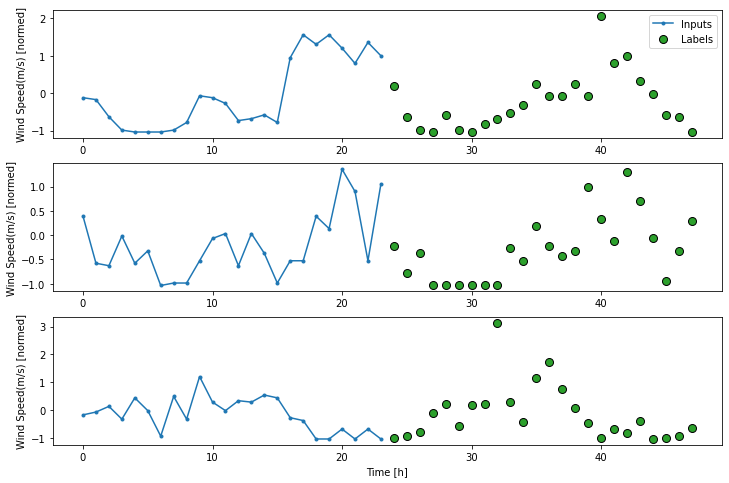

In [114]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

# Baselines


62/62 [==============================] - 0s 1ms/step - loss: 1.7568 - mean_absolute_error: 0.9051
plot_col_index:0
max_n:3
ploating this : [-0.12028494 -0.17117196 -0.62915504 -0.98536414 -1.0362512  -1.0362512
 -1.0362512  -0.98536414 -0.78181607 -0.06939793 -0.12028494 -0.27294597
 -0.7309291  -0.6800421  -0.57826805 -0.78181607  0.94834226  1.5589864
  1.3045514   1.5589864   1.2027774   0.79568124  1.3554384   0.9992293 ] : in figure 0
ploating this : [ 0.38858515 -0.57826805 -0.62915504 -0.01851093 -0.57826805 -0.323833
 -1.0362512  -0.98536414 -0.98536414 -0.52738106 -0.06939793  0.03237608
 -0.62915504  0.03237608 -0.37472    -0.98536414 -0.52738106 -0.52738106
  0.38858515  0.1341501   1.3554384   0.8974553  -0.52738106  1.0501163 ] : in figure 1
ploating this : [-0.17117196 -0.06939793  0.1341501  -0.323833    0.43947217 -0.01851093
 -0.93447715  0.4903592  -0.323833    1.2027774   0.28681114 -0.01851093
  0.33769816  0.28681114  0.5412462   0.43947217 -0.27294597 -0.37472
 -1

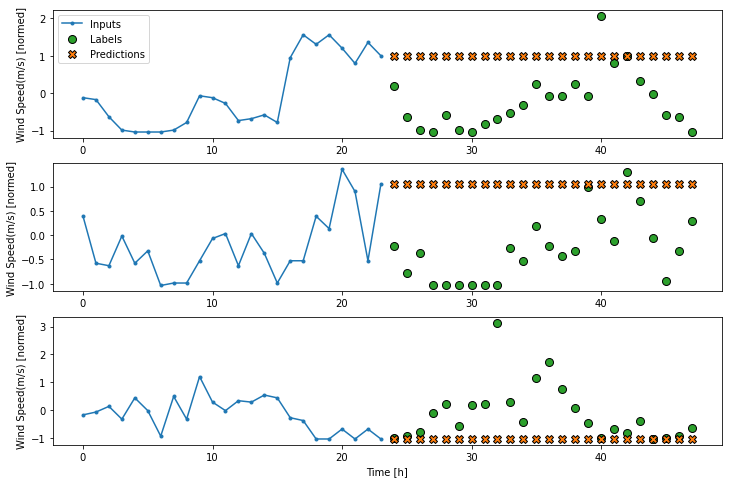

In [115]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

62/62 [==============================] - 0s 1ms/step - loss: 1.2880 - mean_absolute_error: 0.6448
plot_col_index:0
max_n:3
ploating this : [-0.12028494 -0.17117196 -0.62915504 -0.98536414 -1.0362512  -1.0362512
 -1.0362512  -0.98536414 -0.78181607 -0.06939793 -0.12028494 -0.27294597
 -0.7309291  -0.6800421  -0.57826805 -0.78181607  0.94834226  1.5589864
  1.3045514   1.5589864   1.2027774   0.79568124  1.3554384   0.9992293 ] : in figure 0
ploating this : [ 0.38858515 -0.57826805 -0.62915504 -0.01851093 -0.57826805 -0.323833
 -1.0362512  -0.98536414 -0.98536414 -0.52738106 -0.06939793  0.03237608
 -0.62915504  0.03237608 -0.37472    -0.98536414 -0.52738106 -0.52738106
  0.38858515  0.1341501   1.3554384   0.8974553  -0.52738106  1.0501163 ] : in figure 1
ploating this : [-0.17117196 -0.06939793  0.1341501  -0.323833    0.43947217 -0.01851093
 -0.93447715  0.4903592  -0.323833    1.2027774   0.28681114 -0.01851093
  0.33769816  0.28681114  0.5412462   0.43947217 -0.27294597 -0.37472
 -1

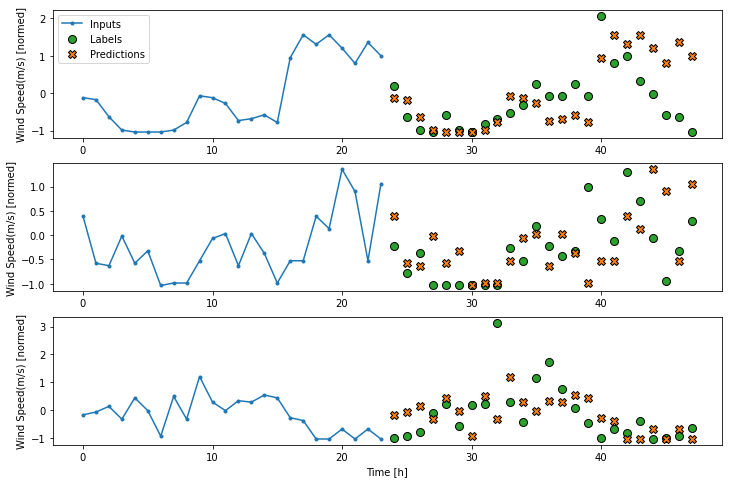

In [116]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

# Single Shot Models
One high level approach to this problem is use a "single-shot" model, where the model makes the entire sequence prediction in a single step.

This can be implemented efficiently as a layers.Dense with OUT_STEPS*features output units. The model just needs to reshape that output to the required (OUTPUT_STEPS, features).

Linear
A simple linear model based on the last input time step does better than either baseline, but is underpowered. The model needs to predict OUTPUT_STEPS time steps, from a single input time step with a linear projection. It can only capture a low-dimensional slice of the behavior, likely based mainly on the time of day and time of year.


62/62 [==============================] - 0s 2ms/step - loss: 0.7202 - mean_absolute_error: 0.5356
plot_col_index:0
max_n:3
ploating this : [-0.12028494 -0.17117196 -0.62915504 -0.98536414 -1.0362512  -1.0362512
 -1.0362512  -0.98536414 -0.78181607 -0.06939793 -0.12028494 -0.27294597
 -0.7309291  -0.6800421  -0.57826805 -0.78181607  0.94834226  1.5589864
  1.3045514   1.5589864   1.2027774   0.79568124  1.3554384   0.9992293 ] : in figure 0
ploating this : [ 0.38858515 -0.57826805 -0.62915504 -0.01851093 -0.57826805 -0.323833
 -1.0362512  -0.98536414 -0.98536414 -0.52738106 -0.06939793  0.03237608
 -0.62915504  0.03237608 -0.37472    -0.98536414 -0.52738106 -0.52738106
  0.38858515  0.1341501   1.3554384   0.8974553  -0.52738106  1.0501163 ] : in figure 1
ploating this : [-0.17117196 -0.06939793  0.1341501  -0.323833    0.43947217 -0.01851093
 -0.93447715  0.4903592  -0.323833    1.2027774   0.28681114 -0.01851093
  0.33769816  0.28681114  0.5412462   0.43947217 -0.27294597 -0.37472
 -1

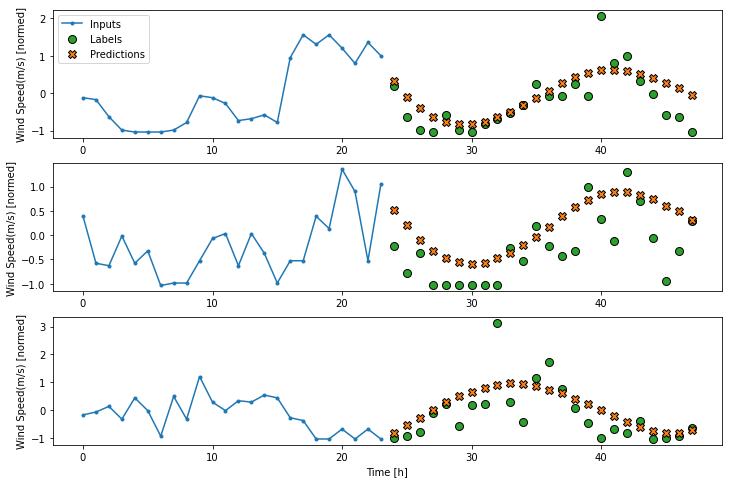

In [117]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

# Dense
Adding a layers.Dense between the input and output gives the linear model more power, but is still only based on a single input timestep.

62/62 [==============================] - 0s 2ms/step - loss: 0.7010 - mean_absolute_error: 0.5278
plot_col_index:0
max_n:3
ploating this : [-0.12028494 -0.17117196 -0.62915504 -0.98536414 -1.0362512  -1.0362512
 -1.0362512  -0.98536414 -0.78181607 -0.06939793 -0.12028494 -0.27294597
 -0.7309291  -0.6800421  -0.57826805 -0.78181607  0.94834226  1.5589864
  1.3045514   1.5589864   1.2027774   0.79568124  1.3554384   0.9992293 ] : in figure 0
ploating this : [ 0.38858515 -0.57826805 -0.62915504 -0.01851093 -0.57826805 -0.323833
 -1.0362512  -0.98536414 -0.98536414 -0.52738106 -0.06939793  0.03237608
 -0.62915504  0.03237608 -0.37472    -0.98536414 -0.52738106 -0.52738106
  0.38858515  0.1341501   1.3554384   0.8974553  -0.52738106  1.0501163 ] : in figure 1
ploating this : [-0.17117196 -0.06939793  0.1341501  -0.323833    0.43947217 -0.01851093
 -0.93447715  0.4903592  -0.323833    1.2027774   0.28681114 -0.01851093
  0.33769816  0.28681114  0.5412462   0.43947217 -0.27294597 -0.37472
 -1

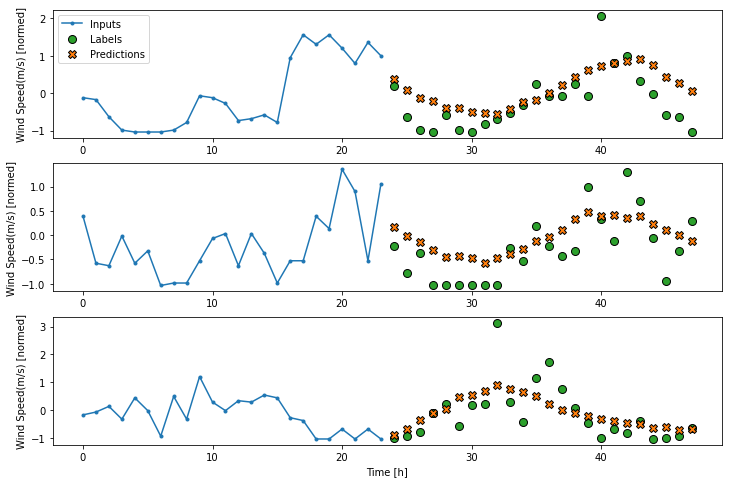

In [118]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

# CNN
A convolutional model makes predictions based on a fixed-width history, which may lead to better performance than the dense model since it can see how things are changing over time

62/62 [==============================] - 0s 2ms/step - loss: 0.7103 - mean_absolute_error: 0.5327
plot_col_index:0
max_n:3
ploating this : [-0.12028494 -0.17117196 -0.62915504 -0.98536414 -1.0362512  -1.0362512
 -1.0362512  -0.98536414 -0.78181607 -0.06939793 -0.12028494 -0.27294597
 -0.7309291  -0.6800421  -0.57826805 -0.78181607  0.94834226  1.5589864
  1.3045514   1.5589864   1.2027774   0.79568124  1.3554384   0.9992293 ] : in figure 0
ploating this : [ 0.38858515 -0.57826805 -0.62915504 -0.01851093 -0.57826805 -0.323833
 -1.0362512  -0.98536414 -0.98536414 -0.52738106 -0.06939793  0.03237608
 -0.62915504  0.03237608 -0.37472    -0.98536414 -0.52738106 -0.52738106
  0.38858515  0.1341501   1.3554384   0.8974553  -0.52738106  1.0501163 ] : in figure 1
ploating this : [-0.17117196 -0.06939793  0.1341501  -0.323833    0.43947217 -0.01851093
 -0.93447715  0.4903592  -0.323833    1.2027774   0.28681114 -0.01851093
  0.33769816  0.28681114  0.5412462   0.43947217 -0.27294597 -0.37472
 -1

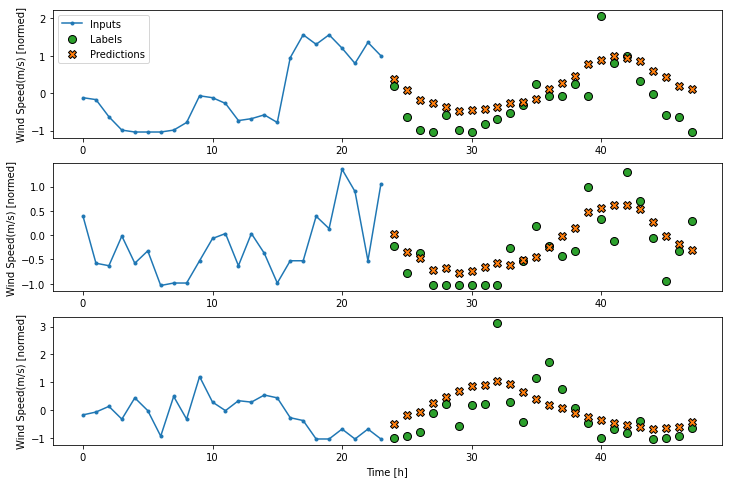

In [119]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

# RNN
A recurrent model can learn to use a long history of inputs, if it's relevant to the predictions the model is making. Here the model will accumulate internal state for 24h, before making a single prediction for the next 24h.

In this single-shot format, the LSTM only needs to produce an output at the last time step, so set return_sequences=False

62/62 [==============================] - 0s 5ms/step - loss: 0.7686 - mean_absolute_error: 0.5955
plot_col_index:0
max_n:3
ploating this : [-0.12028494 -0.17117196 -0.62915504 -0.98536414 -1.0362512  -1.0362512
 -1.0362512  -0.98536414 -0.78181607 -0.06939793 -0.12028494 -0.27294597
 -0.7309291  -0.6800421  -0.57826805 -0.78181607  0.94834226  1.5589864
  1.3045514   1.5589864   1.2027774   0.79568124  1.3554384   0.9992293 ] : in figure 0
ploating this : [ 0.38858515 -0.57826805 -0.62915504 -0.01851093 -0.57826805 -0.323833
 -1.0362512  -0.98536414 -0.98536414 -0.52738106 -0.06939793  0.03237608
 -0.62915504  0.03237608 -0.37472    -0.98536414 -0.52738106 -0.52738106
  0.38858515  0.1341501   1.3554384   0.8974553  -0.52738106  1.0501163 ] : in figure 1
ploating this : [-0.17117196 -0.06939793  0.1341501  -0.323833    0.43947217 -0.01851093
 -0.93447715  0.4903592  -0.323833    1.2027774   0.28681114 -0.01851093
  0.33769816  0.28681114  0.5412462   0.43947217 -0.27294597 -0.37472
 -1

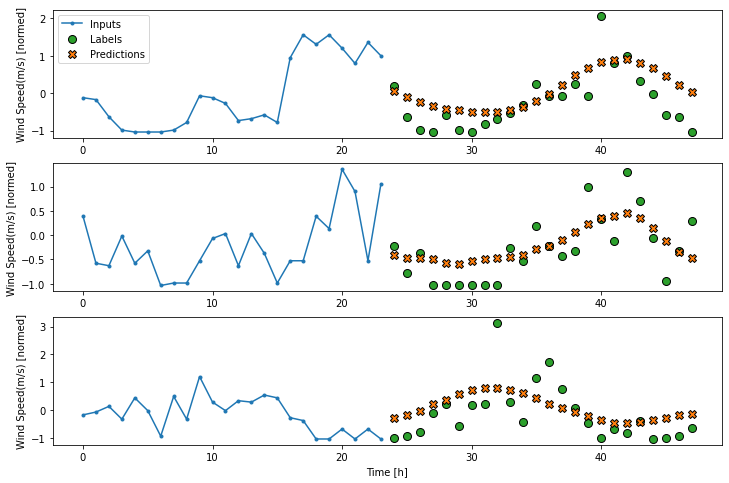

In [120]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

# Advanced: Autoregressive model
The above models all predict the entire output sequence in a single step.

In some cases it may be helpful for the model to decompose this prediction into individual time steps. Then each model's output can be fed back into itself at each step and predictions can be made conditioned on the previous one, like in the classic Generating Sequences With Recurrent Neural Networks.

One clear advantage to this style of model is that it can be set up to produce output with a varying length.

You could take any of the single-step multi-output models trained in the first half of this tutorial and run in an autoregressive feedback loop, but here you'll focus on building a model that's been explicitly trained to do that.

This code only builds an autoregressive RNN model, but this pattern could be applied to any model that was designed to output a single timestep.

The model will have the same basic form as the single-step LSTM models: An LSTM followed by a layers.Dense that converts the LSTM outputs to model predictions.

A layers.LSTM is a layers.LSTMCell wrapped in the higher level layers.RNN that manages the state and sequence results for you (See Keras RNNs for details).

In this case the model has to manually manage the inputs for each step so it uses layers.LSTMCell directly for the lower level, single time step interface

In [121]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [122]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [124]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [125]:
#This method returns a single time-step prediction, and the internal state of the LSTM
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 9])

In [126]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [127]:
#Test Run on the examples input
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 9)


62/62 [==============================] - 0s 6ms/step - loss: 0.7300 - mean_absolute_error: 0.5810
plot_col_index:0
max_n:3
ploating this : [-0.12028494 -0.17117196 -0.62915504 -0.98536414 -1.0362512  -1.0362512
 -1.0362512  -0.98536414 -0.78181607 -0.06939793 -0.12028494 -0.27294597
 -0.7309291  -0.6800421  -0.57826805 -0.78181607  0.94834226  1.5589864
  1.3045514   1.5589864   1.2027774   0.79568124  1.3554384   0.9992293 ] : in figure 0
ploating this : [ 0.38858515 -0.57826805 -0.62915504 -0.01851093 -0.57826805 -0.323833
 -1.0362512  -0.98536414 -0.98536414 -0.52738106 -0.06939793  0.03237608
 -0.62915504  0.03237608 -0.37472    -0.98536414 -0.52738106 -0.52738106
  0.38858515  0.1341501   1.3554384   0.8974553  -0.52738106  1.0501163 ] : in figure 1
ploating this : [-0.17117196 -0.06939793  0.1341501  -0.323833    0.43947217 -0.01851093
 -0.93447715  0.4903592  -0.323833    1.2027774   0.28681114 -0.01851093
  0.33769816  0.28681114  0.5412462   0.43947217 -0.27294597 -0.37472
 -1

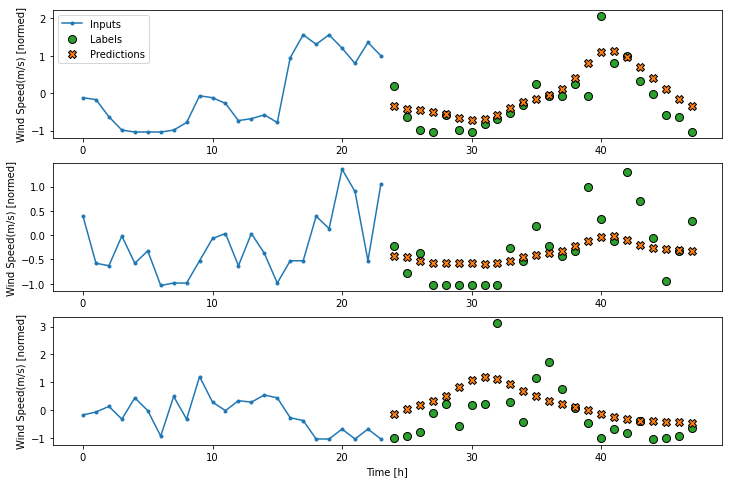

In [128]:
#Trainning the model
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

# Performance

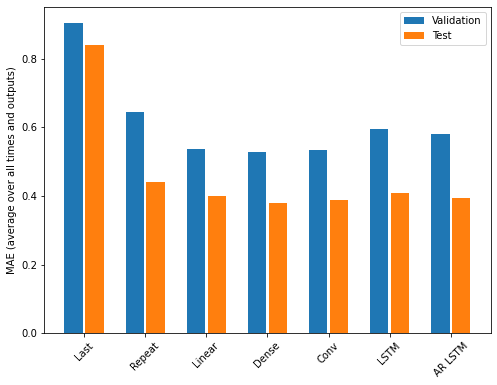

In [129]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [130]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.8400
Repeat  : 0.4408
Linear  : 0.4010
Dense   : 0.3779
Conv    : 0.3875
LSTM    : 0.4096
AR LSTM : 0.3941
